In [0]:
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from collections import Counter

import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import coo_matrix

from sklearn.cluster import AgglomerativeClustering
from KernelTreelets import kernel_treelets_SVC

In [0]:
dataset = np.genfromtxt(r"MPE.csv", delimiter=',', skip_header=1)
dataset = dataset[:, ~np.all(np.isnan(dataset), axis=0)]
dataset = (dataset - np.nanmean(dataset, axis=0)) / np.nanstd(dataset, axis=0)
imp_dataset = SimpleImputer().fit_transform(dataset)
labels = np.genfromtxt(r"Data_Cortex_Nuclear.csv", delimiter=',', skip_header=1, dtype=str)[:, -1]
labelmat = labels[:,None] == labels
labelgraph = []
for i in range(len(labels)):
    for j in range(i):
        if labels[i] == labels[j]:
            labelgraph.append((j, i))

In [0]:
print("|E| = {}".format(len(labelgraph)))
print("|V| = {}".format(np.max(labelgraph) + 1))

|E| = 73035
|V| = 1080


In [0]:
class nan_kernel_rbf:
	def __init__ (self, sigma=1):
		self.gamma = 1 / (2 * sigma * sigma)

	def __call__ (self, X):
		a, b = X.shape
		X = np.asarray(X).reshape((a, 1, b))
		diff = np.nanmean((X - X.swapaxes(1, 2)) ** 2, axis=0)
		return np.exp(- diff * diff * self.gamma)


In [0]:
ktc = kernel_treelets_SVC(nan_kernel_rbf(0.125), number_of_clusters=15, max_sample=2000, verbose=False)
ktc.fit(dataset.T)

In [0]:
ac_ward = AgglomerativeClustering(compute_full_tree=True, linkage='ward').fit(imp_dataset)

In [0]:
ac_complete = AgglomerativeClustering(compute_full_tree=True, linkage='complete').fit(imp_dataset)

In [0]:
ac_average = AgglomerativeClustering(compute_full_tree=True, linkage='average').fit(imp_dataset)

In [0]:
ac_single = AgglomerativeClustering(compute_full_tree=True, linkage='single').fit(imp_dataset)

In [0]:
def confmat(graph, tree):
    E = len(graph)
    V = np.max(graph) + 1
    db = np.zeros(V, dtype=int)
    a4 = np.zeros(V, dtype=int)
    ufg = {x: np.zeros(V, dtype=bool) for x in range(V)}
    for x in range(V):
        ufg[x][x] = True
    for i in range(V - 1):
        p = tree[i][0]
        q = tree[i][1]
        db[i + 1] = 2 * ufg[p].sum() * ufg[q].sum()
        a4[i + 1] = 2 * labelmat[ufg[p]][:, ufg[q]].sum()
        ufg[i + V] = np.logical_or(ufg[p], ufg[q])
        ufg.pop(p)
        ufg.pop(q)

    a4 = np.cumsum(a4)
    db = np.cumsum(db)
    a2 = db - a4
    # a1 = V * V - 2 * E - a2 - V 
    # a3 = 2 * E - a4
    tp = a4 / 2 / E
    fp = a2 / (V * V - 2 * E - V)
    return (fp, tp)

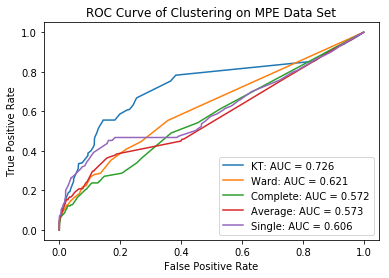

In [17]:
acs = [ktc, ac_ward, ac_complete, ac_average, ac_single]
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve of Clustering on MPE Data Set")
pairs = [confmat(labelgraph, x.children_) for x in acs]
methods = [plt.plot(x[0], x[1]) for x in pairs]
names = ["KT", "Ward", "Complete", "Average", "Single"]
auc = [1 - np.trapz(x[0], x[1]) for x in pairs]
plt.legend([i[0] for i in methods], [names[i] + ": AUC = {:.3f}".format(auc[i]) for i in range(len(methods))])
plt.savefig('dcn.jpg', dpi=1000)
plt.show()